In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, Callback
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAPE, MAE, MASE, RMSE
from pytorch_forecasting.metrics import NormalDistributionLoss

from sktime.forecasting.naive import NaiveForecaster

In [3]:
class EpochCallback(Callback):
        
    def on_validation_epoch_end(self, trainer, module):
        print(trainer.progress_bar_metrics)

In [409]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

## Data Loading

In [410]:
btc_df = pd.read_csv('BTC-USD.csv', usecols = ['Date','Open','Adj Close'])

In [411]:
btc_df.head()

,Date,Open,Adj Close
0,2014-09-17,465.864014,457.334015
1,2014-09-18,456.859985,424.440002
2,2014-09-19,424.102997,394.795990
3,2014-09-20,394.673004,408.903992
4,2014-09-21,408.084991,398.821014


## Data Splitting

In [412]:
train_size = 0.8

train_df = btc_df.iloc[:int(len(btc_df)*train_size)]
test_df = btc_df.iloc[int(len(btc_df)*train_size):]

## Hyperparameter Tuning

- widths; [256, 512, 2048]
- num of blocks; 
- weight decay (regularization); 
- learning rate; 
- lookback window. 

| Hyperparameter | #1 | #2 | #3 | #4 | #5 |
| --- | ----------- |----------- |----------- | ----------- | ----------- |
| lag time | 14 | .. | .. | .. | 21 |
| lead time | 1 | .. | .. | .. | .. |
| num_blocks | [3,3] | .. | [1,1]| [5,5] | .. |
| width | [32, 512] | [32, 256] | [32, 512]| .. | .. |
| weight_decay | 0.001 | .. | .. | .. | .. |
| learning_rate | 1e-2 | .. | .. | .. | .. |
| val_size | 0.2 | .. | .. | .. | .. |
| rmse | 1.66e3 | 1.665384e+03 | 3.039785e+03 | 1.414409e+03 | 1.040279e+03 |

Comment: The prediction is almost a flat line for lag time 7 days or learning rate 1e-4 

| Hyperparameter | #1 | #2 | #3 | #4 | #5 | #6 (with Open) |
| --- | ----------- |----------- |----------- | ----------- | ----------- | ----------- | 
| lag time | 21 | 28 | 35 | 42 | 60 | 42 | 42 |
| lead time | 7 | .. | .. | .. | .. | .. | 
| num_blocks | [5,5] | .. | .. | .. | .. | .. | 
| width | [32, 512] | .. | .. | .. | .. | .. |
| weight_decay | 0.001 | .. | .. | .. | .. | .. | 
| learning_rate | 1e-2 | .. | .. | .. | .. | .. |
| val_size | 0.2 | .. | .. | .. | .. | .. |
| rmse | 2.520853e+03 | 2.497625e+03 | 2.430953e+03| 2.337913e+03| 2.462547e+03 | 2.407206e+03 |

## Data Formatting

In [413]:
lag_time = 35 # num of steps input to the model >= lead time, x1, x2, ...
lead_time = 7 # lookahead, predicting horizon. 
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [414]:
train_df

,time_idx,Date,Open,Adj Close,group_ids
0,0,2014-09-17,465.864014,457.334015,0
1,1,2014-09-18,456.859985,424.440002,0
2,2,2014-09-19,424.102997,394.795990,0
3,3,2014-09-20,394.673004,408.903992,0
4,4,2014-09-21,408.084991,398.821014,0
...,...,...,...,...,...
2386,2386,2021-03-30,57750.132813,58917.691406,0
2387,2387,2021-03-31,58930.277344,58918.832031,0
2388,2388,2021-04-01,58926.562500,59095.808594,0
2389,2389,2021-04-02,59098.878906,59384.312500,0


## Data Preparation for N-BEATS

In [415]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'Date'], value_vars=['Open', 'Adj Close'], var_name='group_ids')
train_df_nbeats.shape

(4782, 4)

In [416]:
train_df_nbeats.tail()

,time_idx,Date,group_ids,value
4777,2386,2021-03-30,Adj Close,58917.691406
4778,2387,2021-03-31,Adj Close,58918.832031
4779,2388,2021-04-01,Adj Close,59095.808594
4780,2389,2021-04-02,Adj Close,59384.312500
4781,2390,2021-04-03,Adj Close,57603.890625


In [417]:
# define dataset
valid_size = 0.2  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
context_length = max_encoder_length
prediction_length = max_prediction_length

In [418]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
)

In [419]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Model Training

In [420]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
epoch_callback = EpochCallback()

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback, epoch_callback],
    limit_train_batches=1.0,
)

net = NBeats.from_dataset(
    training,
    learning_rate=1e-2,
    num_blocks=[5,5], 
    log_interval=10,
    log_val_interval=1,
    # weight_decay=1e-2,
    widths=[32, 512],
    # backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.8 M 
-----------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.014    Total estimated model params size (MB)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_l

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42


{'sanity_check_loss': 5.485701560974121}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'train_loss_step': 3.289287567138672, 'val_loss': 3.155059814453125}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.386112689971924, 'val_loss': 2.4760234355926514, 'train_loss_epoch': 4.188849925994873}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.150348424911499, 'val_loss': 2.3819026947021484, 'train_loss_epoch': 2.6240365505218506}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.650763988494873, 'val_loss': 2.3536617755889893, 'train_loss_epoch': 2.36972975730896}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 1.8677626848220825, 'val_loss': 2.4456913471221924, 'train_loss_epoch': 2.2833027839660645}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.2291858196258545, 'val_loss': 2.4033820629119873, 'train_loss_epoch': 2.237229108810425}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.2862420082092285, 'val_loss': 2.391185998916626, 'train_loss_epoch': 2.1846237182617188}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.3291969299316406, 'val_loss': 2.5715506076812744, 'train_loss_epoch': 2.2083442211151123}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.3273141384124756, 'val_loss': 2.572554588317871, 'train_loss_epoch': 2.118858814239502}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 1.9435609579086304, 'val_loss': 2.500041961669922, 'train_loss_epoch': 2.154071569442749}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 2.1816718578338623, 'val_loss': 2.605086326599121, 'train_loss_epoch': 2.048814296722412}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 1.8793436288833618, 'val_loss': 2.5203678607940674, 'train_loss_epoch': 2.028179407119751}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 1.7672557830810547, 'val_loss': 2.7436375617980957, 'train_loss_epoch': 1.9302663803100586}


Validating: 0it [00:00, ?it/s]

{'train_loss_step': 1.7649202346801758, 'val_loss': 2.637336254119873, 'train_loss_epoch': 1.8793485164642334}


## Testing

In [421]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="Adj Close",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Adj Close"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [422]:
len(test_dataset)

557

In [423]:
test_dataloader

In [424]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
print(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

/ssd003/home/lindayuhuang/forecasting-bootcamp/model_implementation/lightning_logs/version_8834108/checkpoints/epoch=13-step=405.ckpt


## Plot Model Forecasts at Max Lead Time

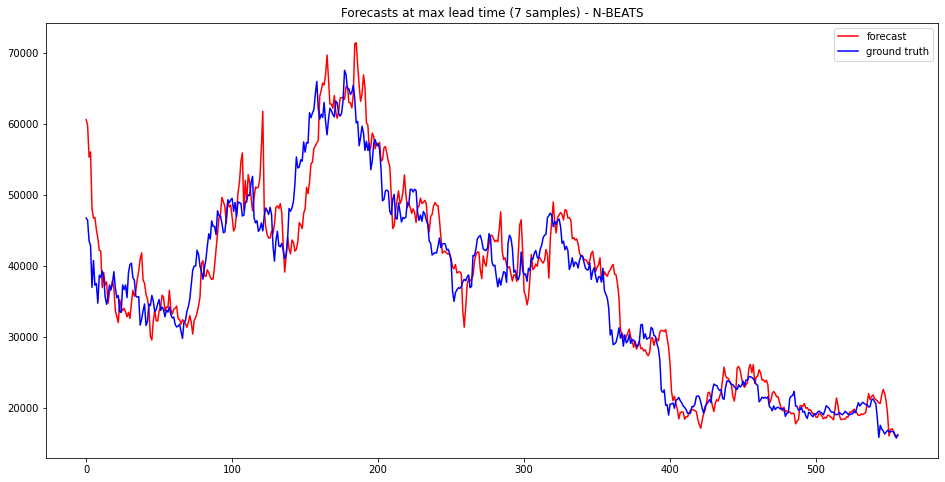

In [425]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(indexes, preds, color='red', label='forecast')
ax.plot(indexes, trues, color='blue', label='ground truth')
ax.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax.legend()

In [426]:
len(predictions_np)

557

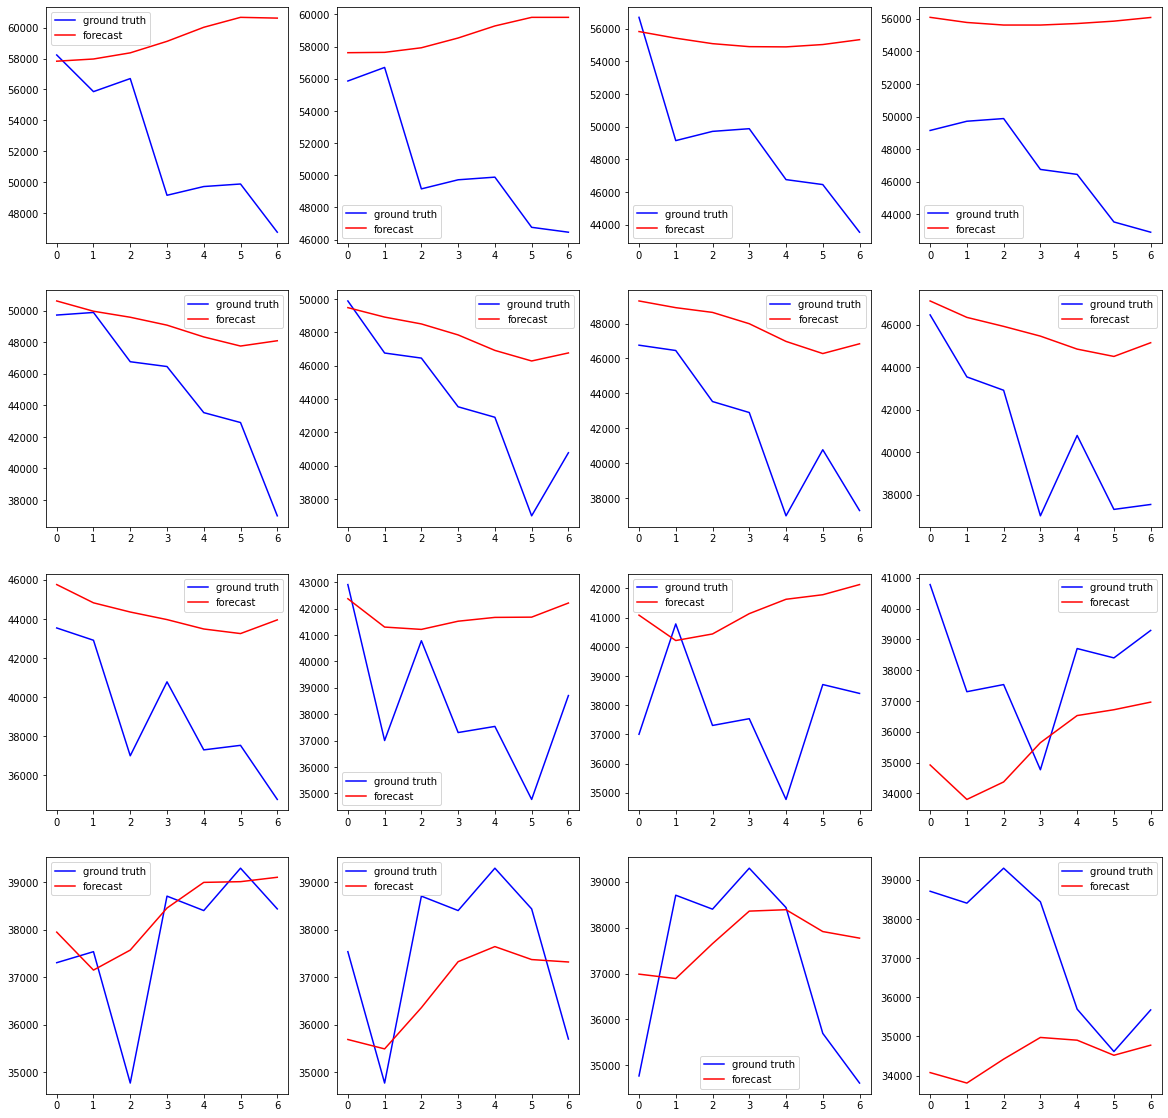

In [427]:
# plot at single time index

fig, axs = plt.subplots(4, 4, figsize=(20,20))
axs = axs.flatten()

for fig_index, example_index in enumerate(range(0, len(predictions_np), 1)):

    if fig_index > len(axs) - 1:
        break

    ground_truth = actuals_np[example_index]
#     print(ground_truth)
    forecast = predictions_np[example_index]
#     print(forecast)

    axs[fig_index].plot(list(range(0, len(forecast))), ground_truth, color='blue', label='ground truth')
    axs[fig_index].plot(list(range(0, len(forecast))), forecast, color='red', label='forecast')
    axs[fig_index].legend()

## Standard evaluation metrics

In [428]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

def compute_baseline_error_metrics(predictions, actuals):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(predictions)):
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=actuals[i], y_pred=predictions[i]))

    return errors

In [429]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

nbeats_errors = compute_baseline_error_metrics(predictions_np, actuals_np)
nbeats_stats = compute_error_statistics(nbeats_errors, 'nbeats')
nbeats_stats['mean']

mse     9.392365e+06
rmse    2.460119e+03
mae     2.161301e+03
mape    5.961161e-02
Name: nbeats_mean_metrics, dtype: float32

## Persistence Model

In [430]:
class ForecastingDataset:

    def __init__(self, data_df, lag_time, lead_time, feature_columns):
        self.n_examples = len(data_df) - lag_time - lead_time + 1
        assert self.n_examples > 0, "Dataset must contain at least one example."
        assert "Date" in data_df.columns or "ds" in data_df.columns, "Source DataFrame must contain a date/ds column."

        self.df = data_df[feature_columns]
        if 'Date' in data_df.columns:
            self.dates = data_df.Date
        elif 'ds' in data_df.columns:
            self.dates = data_df.ds
        self.lag_time = lag_time
        self.lead_time = lead_time

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        input = self.df.iloc[idx:idx+lag_time]
        output = self.df.iloc[idx+lag_time:idx+lag_time+lead_time]
        input_dates = self.dates[idx:idx+lag_time]
        output_dates = self.dates[idx+lag_time:idx+lag_time+lead_time]
        return input, output, input_dates, output_dates

In [431]:
feature_columns = ["Adj Close"]#[col for col in test_df if col.endswith("_CLOSE")]
test_dataset = ForecastingDataset(test_df, lag_time, lead_time, feature_columns)

In [432]:
test_dataset.__len__()

557

In [433]:
baseline_model_persistence = NaiveForecaster(strategy='last')
baseline_model_mean = NaiveForecaster(strategy='mean',window_length=lag_time)

forecasts_persistence = []
forecasts_mean = []

for i in range(len(test_dataset)):
    x, y, x_d, y_d = test_dataset[i]
    
    persistence_fc = baseline_model_persistence.fit_predict(x['Adj Close'], fh=list(range(1, lead_time+1)))
    persistence_fc = pd.Series(persistence_fc.values, index=y_d)
    forecasts_persistence.append(persistence_fc)

    mean_fc = baseline_model_mean.fit_predict(x['Adj Close'], fh=list(range(lead_time)))
    mean_fc = pd.Series(mean_fc.values, index=y_d)
    forecasts_mean.append(mean_fc)

    print(i, end='\r')

In [434]:
def compute_baseline_error_metrics(forecasts, test_dataset):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        x, y, x_d, y_d = test_dataset[i]
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=y['Adj Close'], y_pred=fc))

    return errors, forecasts

persistence_errors, _ = compute_baseline_error_metrics(forecasts_persistence, test_dataset)
mean_errors, _ = compute_baseline_error_metrics(forecasts_mean, test_dataset)

In [435]:
persistence_stats = compute_error_statistics(persistence_errors, 'persistence')
persistence_stats['mean']

mse     7.913484e+06
rmse    2.244099e+03
mae     1.956470e+03
mape    5.359856e-02
Name: persistence_mean_metrics, dtype: float64

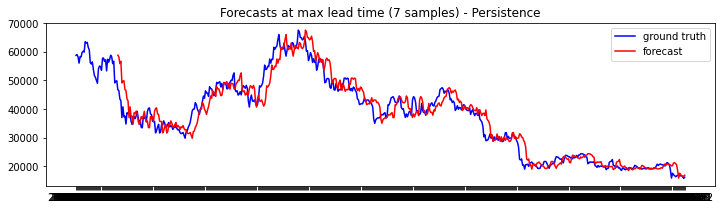

In [436]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts_persistence]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.Date, test_df['Adj Close'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Persistence")
plt.legend(loc='upper right')

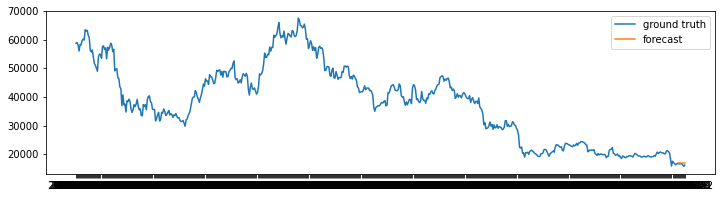

In [437]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['Date', 'Adj Close']]
plt.plot(ground_truth.Date, ground_truth['Adj Close'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts_persistence[-1], label='forecast')
plt.legend()